# Week 10 Practical - Question 2 Solution
## Multi-Task Learning with Siamese Networks

Siamese networks can also be configured for multi-task learning. There are many ways to do this, but a common way is to consider a secondary task on one of the inputs. Using the Week 7 practical solution as a starting point, add a second task to the network. Possible tasks include:
* A classification output, which uses the embedding from one image (such as the anchor image) to classify the face into the identity using a softmax output.
* An image output, that adds a decoder to the embedding to try and reconstruct the original image.	

For both of these, you may also wish to consider appropriate loss weights. Any selection of loss weights should consider both the importance of the tasks, and also the scale of the losses (i.e. are both losses typically in the same range? Or is one much larger or smaller than the other?).

Using the modified network, evaluate the face recognition performance on YaleB, ORL and Yale. As with Question 1, use a simple classifier and feel free to borrow from code such as the week 7 practical solutions. Compare the generalisation ability of the multi-task network to the original single task network.

## Our Approach

In this solution we'll look at the classification output option. The second solution (2b) will look at the second option.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

# for consistency
random.seed(4)

## Code Reuse

This solution is going to make heavy use of code from previous examples. In particular:
* The Week 7 practical solution, which used the face rec datasets with a triplet network. The data loading, network structure, face rec classifier training and evaluation is taken from here. Really, we're just adding a second task to this network

Given the heavy code reuse, commentary with this solution will be somewhat sparse, and will focus on the new bits.

## Data Loading

Load YaleB, reshape into images, and display it. We'll also convert the labels to a categorical here as we want to use those with a classification head.

In [2]:
yale_b = scipy.io.loadmat('../../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

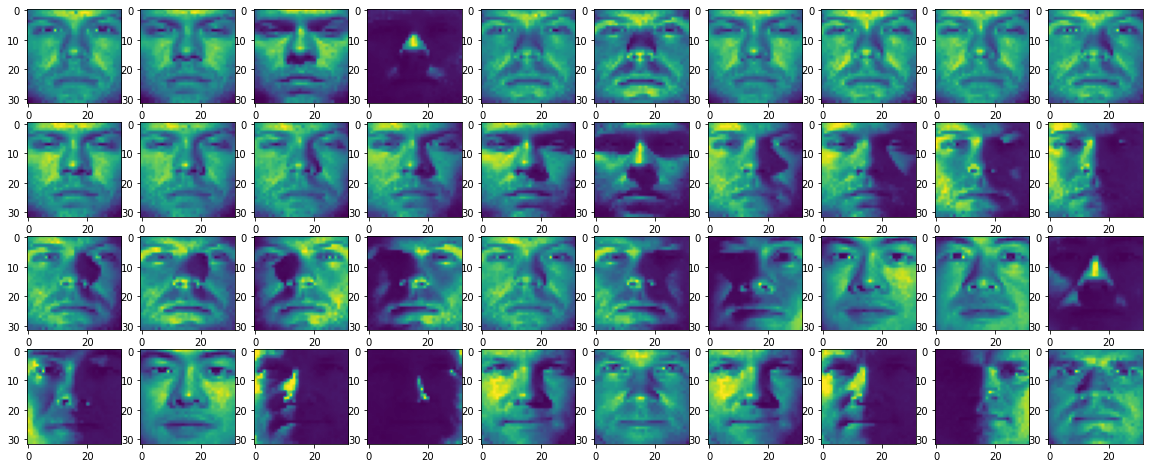

In [3]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

## Data Extraction Functions

Largely from the Week 7 practical solution, however we are also getting some categorical labels out of the triplet functions.

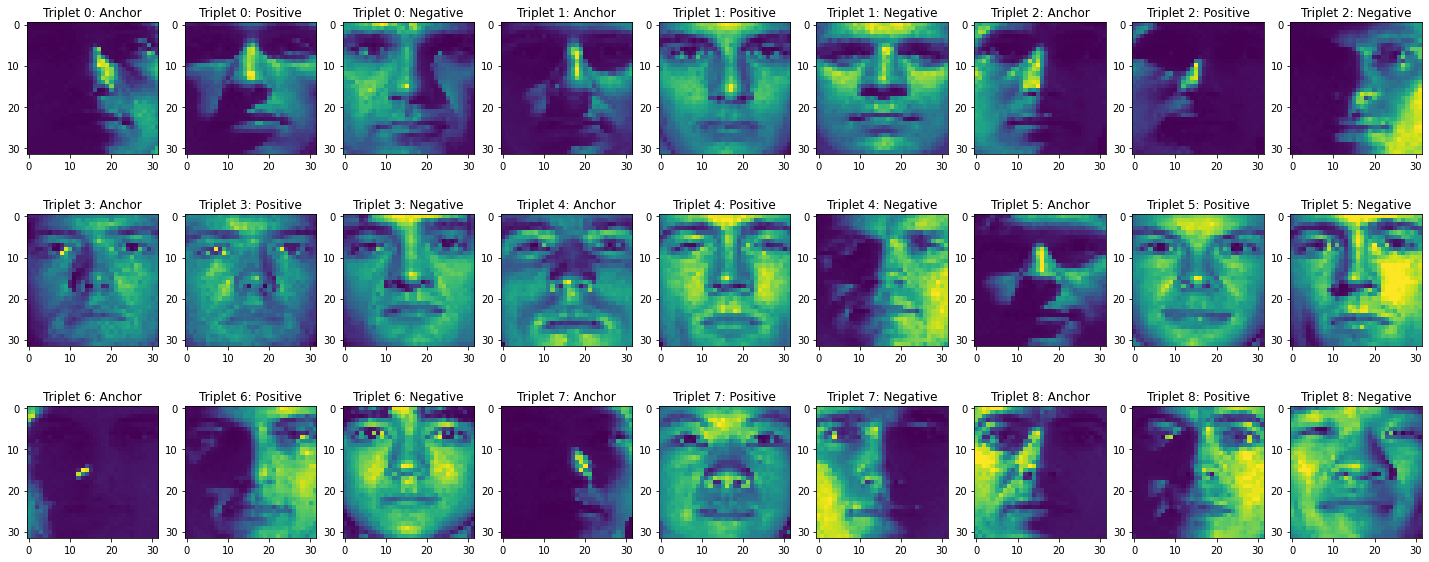

In [4]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, labels_categorical, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    out_labels = numpy.zeros((batch_size, numpy.shape(labels_categorical)[1]))
        
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        out_labels[i, :] = labels_categorical[idx1, :]
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c], out_labels

def TripleGenerator(imgs, labels, labels_categorical, batch_size):
    while True:
        [image_a, image_b, image_c], out_labels = GetTripletData(imgs, labels, labels_categorical, batch_size)
        yield [image_a, image_b, image_c], [out_labels]
        
test = TripleGenerator(train_fea_reshape, train_gnd, keras.utils.to_categorical(train_gnd), 9)
x, anchor_labels = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triplet ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Negative')        

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

## The Network

Largely taken from the week 7 solution, however below we also have this id_loss_layer that captures some identity information. This is attached to the embedding from the anchor image.

In [6]:
embedding_size = 32
dummy_input = keras.Input((32, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((32, 32, 1), name='Anchor')
input_positive = keras.Input((32, 32, 1), name='Positive')
input_negative = keras.Input((32, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
id_loss_layer = layers.Dense(39, activation='softmax', name='id_loss_layer')(embedding_anchor)
triplet_loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')(
    [embedding_anchor, embedding_positive, embedding_negative])

In [7]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], 
                              outputs=[id_loss_layer, triplet_loss_layer])
triplet_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor (InputLayer)             [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Positive (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           552056      Anchor[0][0]                     
                                                                 Positive[0][0]               

In [8]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop(), loss=['categorical_crossentropy', None])

batch_size = 128
triplet_train_x, train_labels = GetTripletData(train_fea_reshape, train_gnd, 
                                               keras.utils.to_categorical(train_gnd), 20000)
triplet_test_x, test_labels = GetTripletData(test_fea_reshape, test_gnd, 
                                             keras.utils.to_categorical(test_gnd), 1000)

triplet_network.fit(triplet_train_x, train_labels, batch_size=128, epochs=20, 
                    validation_data=(triplet_test_x, test_labels))

Epoch 1/20
  2/157 [..............................] - ETA: 13s - loss: 123.7196 - id_loss_layer_loss: 3.9787  

2022-01-21 15:01:34.383608: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 86.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-21 15:01:34.383720: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 86.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


157/157 [==============================] - ETA: 0s - loss: 91.9473 - id_loss_layer_loss: 3.5320

2022-01-21 15:01:49.174099: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 23.80MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-21 15:01:49.174854: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.86MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-21 15:01:49.175028: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.86MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-21 15:01:49.176872: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Al

157/157 [==============================] - 21s 97ms/step - loss: 91.9473 - id_loss_layer_loss: 3.5320 - val_loss: 93.6015 - val_id_loss_layer_loss: 3.5679
Epoch 2/20
157/157 [==============================] - 14s 91ms/step - loss: 37.8301 - id_loss_layer_loss: 1.9758 - val_loss: 21.5588 - val_id_loss_layer_loss: 1.4624
Epoch 3/20
157/157 [==============================] - 14s 91ms/step - loss: 18.8136 - id_loss_layer_loss: 0.9769 - val_loss: 11.4511 - val_id_loss_layer_loss: 0.7435
Epoch 4/20
157/157 [==============================] - 14s 90ms/step - loss: 10.4038 - id_loss_layer_loss: 0.4597 - val_loss: 6.1873 - val_id_loss_layer_loss: 0.3409
Epoch 5/20
157/157 [==============================] - 15s 94ms/step - loss: 6.6376 - id_loss_layer_loss: 0.2456 - val_loss: 4.2870 - val_id_loss_layer_loss: 0.1501
Epoch 6/20
157/157 [==============================] - 14s 89ms/step - loss: 4.2753 - id_loss_layer_loss: 0.1484 - val_loss: 3.4572 - val_id_loss_layer_loss: 0.0915
Epoch 7/20
157/157 [

Looking at our embeddings, we see that we still have the very tight grouping that we got with just the triplet network.

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


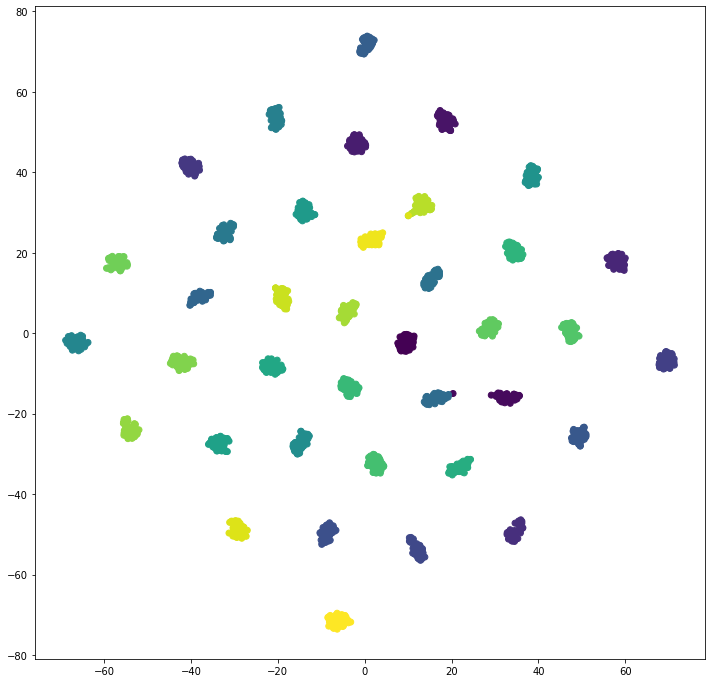

In [9]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

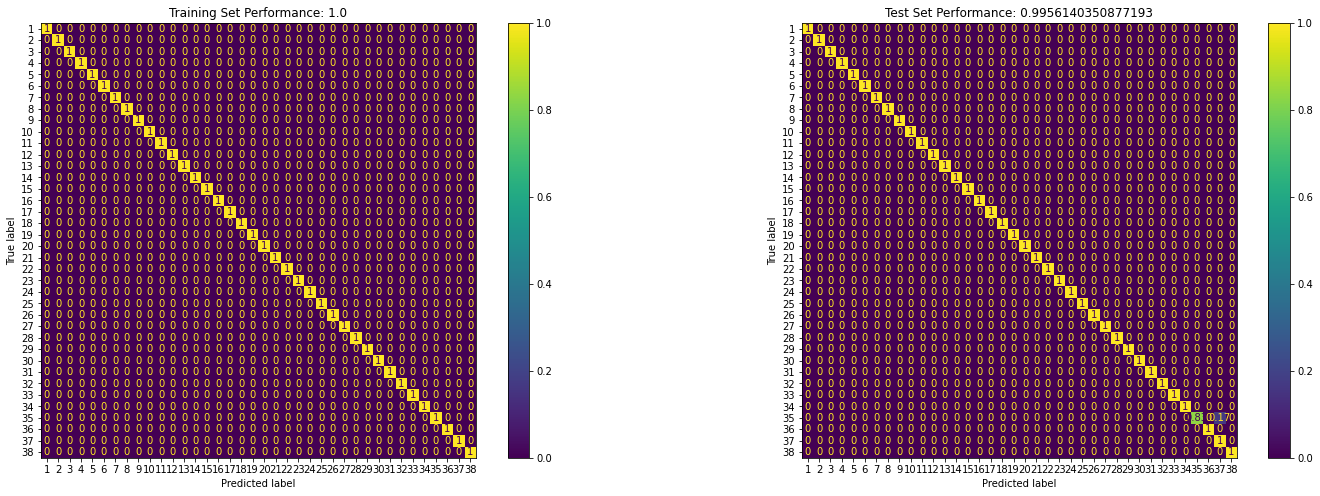

In [10]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));  

test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_siam.fit(embeddings, train_gnd)
eval_model(cknn_siam, embeddings, train_gnd, test_embeddings, test_gnd) 

And results wise, much like we saw with the original triplet example, we're doing really well.

## Generalisation Time

As per Q1, we're really just using Week 7 practical solution code here. Let's start with ORL.

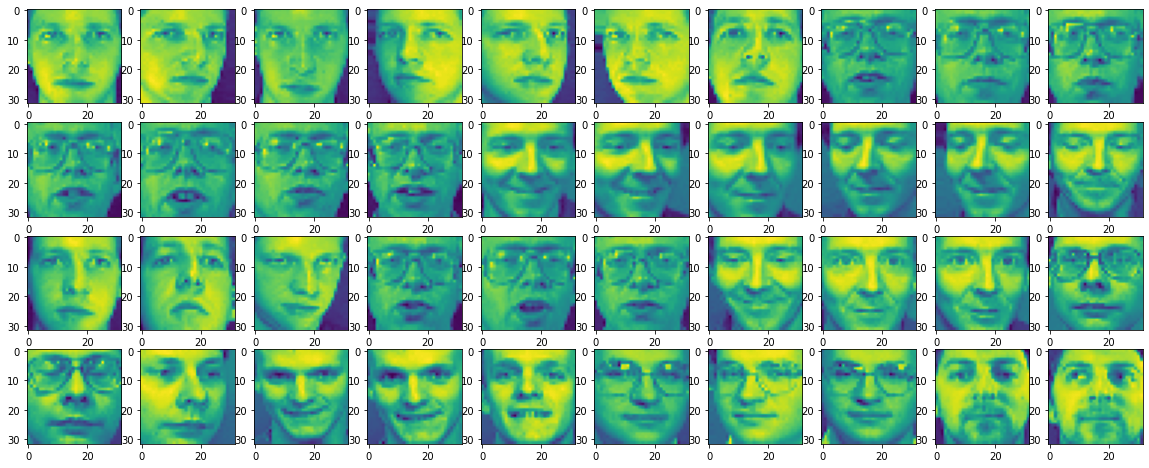

In [11]:
orl = scipy.io.loadmat('../../data/ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

train_fea_reshape = numpy.reshape(train_orl_fea.transpose(), (32, 32, 1, len(train_orl_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_orl_fea.transpose(), (32, 32, 1, len(test_orl_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


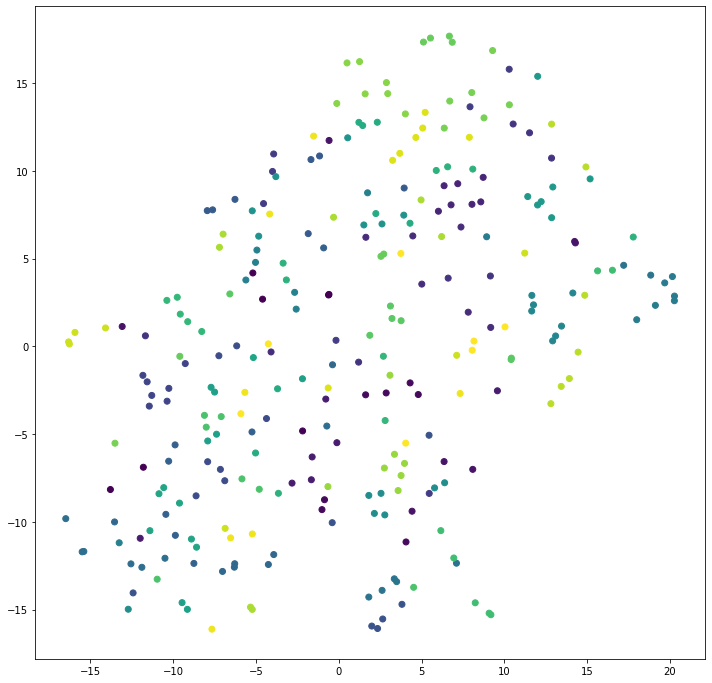

In [12]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_orl_gnd.flatten());

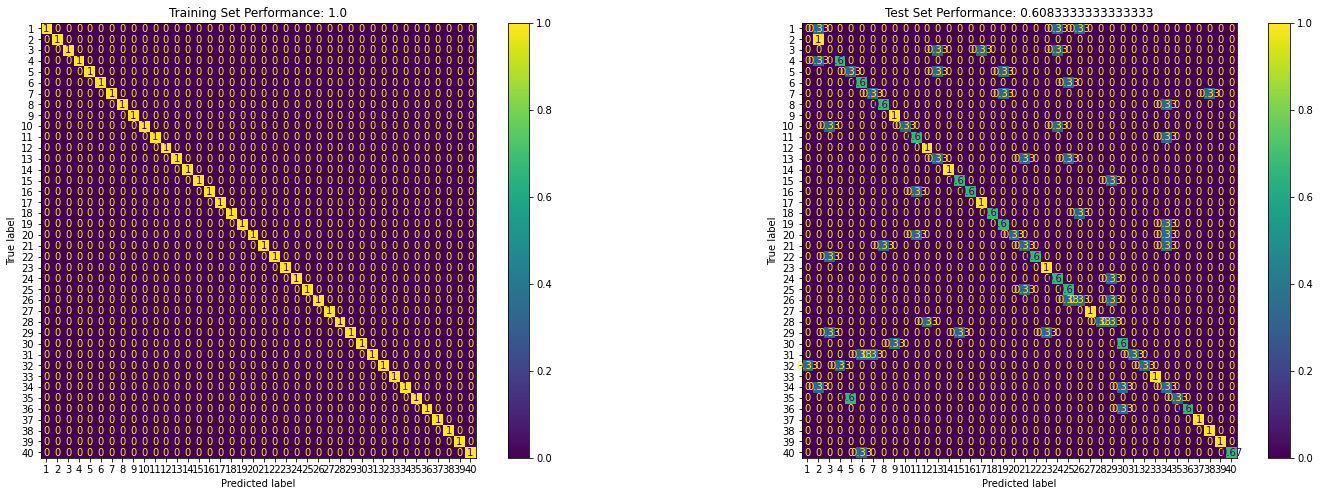

In [13]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_orl_gnd)
eval_model(cknn_siam, embeddings, train_orl_gnd, test_embeddings, test_orl_gnd) 

Performance wise, this is not great, and is really pretty similar to what we say with the triplet network

On to Yale.

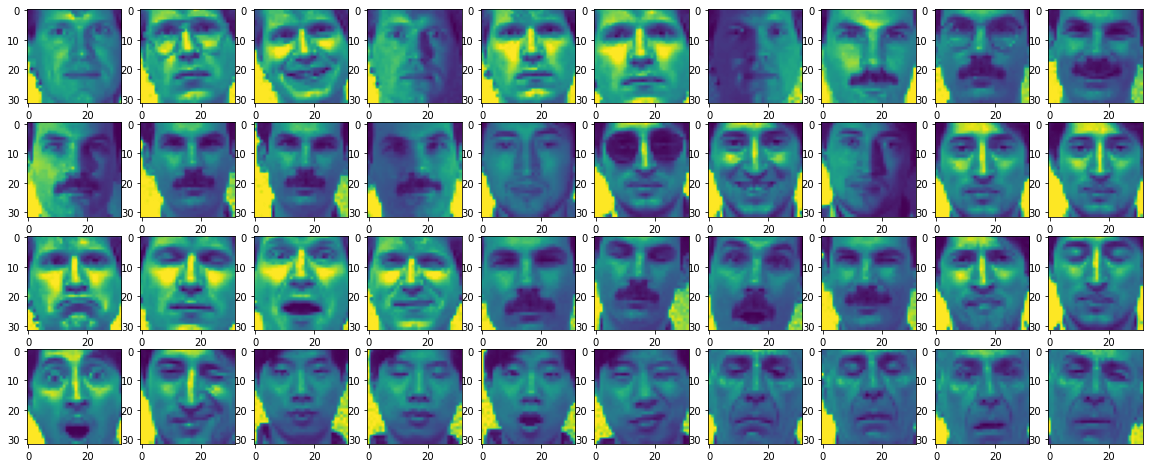

In [14]:
yale = scipy.io.loadmat('../../data/Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

train_fea_reshape = numpy.reshape(train_yale_fea.transpose(), (32, 32, 1, len(train_yale_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_yale_fea.transpose(), (32, 32, 1, len(test_yale_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


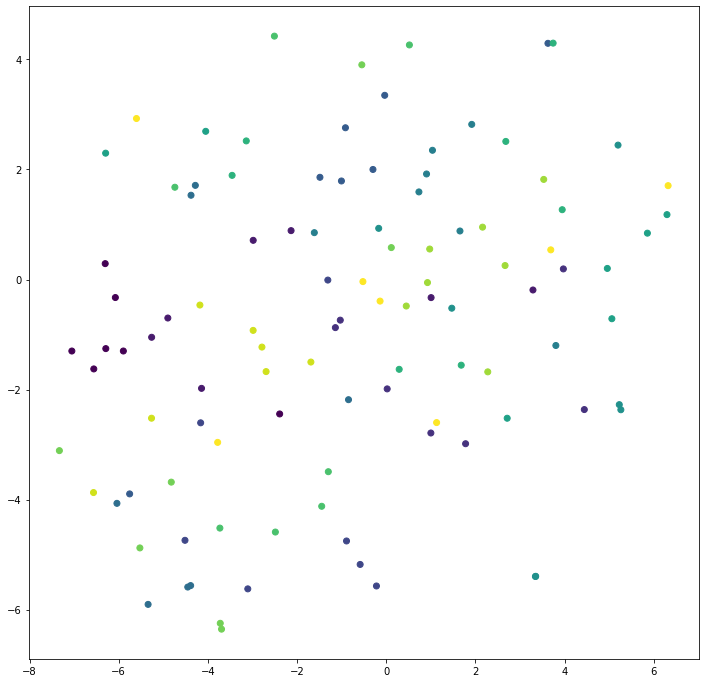

In [15]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_yale_gnd.flatten());

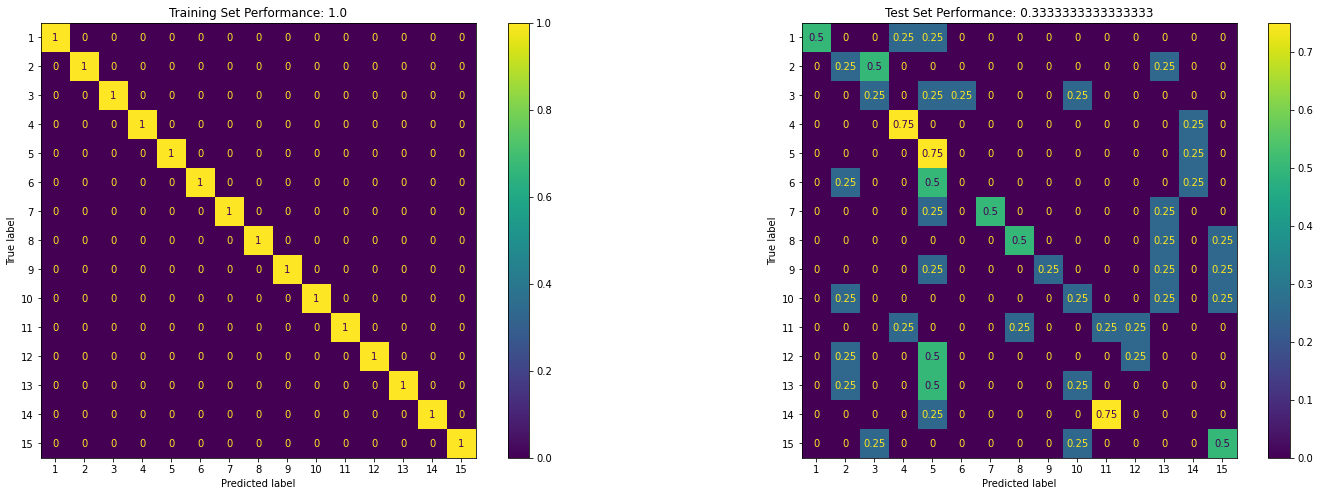

In [16]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_yale_gnd)
eval_model(cknn_siam, embeddings, train_yale_gnd, test_embeddings, test_yale_gnd) 

Again, this is not too encouraging, and is quite a bit worse than Q1.

## What gives? Should this not work?

So why does this not solve all of the triplet networks issues? Let's consider our two tasks:
* Our triplet loss task, where we're trying to make things of the same class close together, and things of different classes far apear
* Our classification task, where we're trying to recognise each embedding into it's correct class

The second task is, effectively, doing the same thing as the first. While we have two tasks, both are very specific to the target data - so the issue we have with YaleB (that it's images don't quite look like what we see in the other face datasets) is not addressed by the second task.

The message here really is that we can't just add a second task and guarantee that it will make things better. Depending what we're trying to achieve, some secondary tasks will just reinforce the existing issues that we have.